# **Brain Tumor Detection and Classification**

##[Table of Contents](#scrollTo=hrE95c82neaw)

>[1. Initial Setup](#scrollTo=B1FSdSRQkDnf)

>>[Some Basic Information](#scrollTo=7NB9MXXzl36x)

>[2. EDA (Exploratory Data Analysis)](#scrollTo=O59DwqXOmqcM)

>>[2.1. Images Statistical Data](#scrollTo=6AW6a2QaMT7I)

>>[2.2. Labels Statistical Data](#scrollTo=8npHJAlFMdtR)

>>[2.3. Coordinates Statistical Data](#scrollTo=E37zVtmS1Zg4)

>>[2.3. Data Visualization](#scrollTo=Q9p6u2RhONCU)



# **1. Initial Setup**

In [1]:
!pip install --upgrade -q gdown

from warnings import filterwarnings
from gdown    import download
from os.path  import isdir
from os       import (getcwd,
                      mkdir)


output_file = 'dataset.zip'
file_id = '18cPvbZrH5CUWhhIGZOSkiBSnCA0GPC1z'
download(f'https://drive.google.com/uc?id={file_id}', output_file, quiet=True)

!unzip -o -q ./{output_file} -d .

filterwarnings('ignore', category=DeprecationWarning)
filterwarnings('ignore', category=FutureWarning)

# Figures and datasets export directories
if not isdir(f'{getcwd()}/../datasets'):
    mkdir(f'{getcwd()}/../datasets')
if not isdir(f'{getcwd()}/../plots'):
    mkdir(f'{getcwd()}/../plots')

## **Some Basic Information**

- Some images doesn't have any tumor to detect;

- Each label file (.txt) has the following pattern in each line (if it's tumourous):
    - \<label\> \<coordinate 1\> \<coordinate 2\> \<coordinate 3\> \<coordinate 4\>.

- The dataset is already splitted between train, validation and test sets (70%, 20% and 10%, respectively).

In [2]:
# An instance with no tumour to detect
!cat 'Brain Tumor Detection/train/labels/volume_82_slice_53_jpg.rf.9b9cb2b7f64aad43328bb42413e71a0d.txt'

In [3]:
# An instance with all tumour types to detect and their coordinates
!cat 'Brain Tumor Detection/train/labels/volume_348_slice_114_jpg.rf.65558903adffdcfb7286287dda3477dd.txt'

0 0.7086330935251799 0.5757575757575758 0.17985611510791366 0.12121212121212122
1 0.7086330935251799 0.6136363636363636 0.2949640287769784 0.22727272727272727
2 0.7050359712230215 0.6060606060606061 0.2446043165467626 0.22727272727272727

# **2. EDA (Exploratory Data Analysis)**

In [4]:
!pip install pycryptodomex -q

from Cryptodome.Hash import SHA512
from os              import listdir
from os.path         import isfile
from os.path         import join
import numpy as np
import cv2   as cv


hash_function = SHA512.new()


def count_duplicates(data_dir: str) -> tuple[int, list]:
    '''
    Counts duplicated images and which of them aren't tumourous
    '''
    no_tumour = 0
    images, labels, hashes = list(), list(), list()
    img_list = listdir(join(data_dir, 'images'))

    for filename in img_list:

        if filename.endswith('.jpg') or filename.endswith('.png'):

            img_path = join(data_dir, 'images', filename)
            img = cv.imread(img_path)

            # Calculates the hash for each image (needs conversion to bytes)
            _, image_bytes = cv.imencode('.jpg', img)
            image_bytes = image_bytes.tobytes()
            hash_function.update(image_bytes)
            img_hash = hash_function.hexdigest()
            hashes.append(img_hash)

            label_path = join(data_dir, 'labels', filename.replace('.jpg', '.txt'))

            if isfile(label_path):
                with open(label_path, 'r') as label_file:
                    line = label_file.readline().strip()

                    if not line:
                        no_tumour += 1
                        continue

    return no_tumour, hashes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 13.5 MB/s eta 0:00:00


- All images are labeled (even if it has no tumors);

- No duplicated instances;

- The portion of images with no tumor is minimal;

- Low number of images with no tumour can lead to overfitting of the model (e.g., tends to detect at least one tumour every time).

In [5]:
image_hashes = list()
total_images, n_labels, unlabeled = 0, 0, 0
dirs = ['Brain Tumor Detection/train', 'Brain Tumor Detection/valid', 'Brain Tumor Detection/test']

for dir in dirs:
    partial_unlabeled, partial_hash = count_duplicates(data_dir=dir)
    unlabeled += partial_unlabeled
    image_hashes += partial_hash
    n_labels += len(listdir(f'{dir}/labels'))
    total_images += len(listdir(f'{dir}/images'))

proportion = (unlabeled / total_images) * 100
duplicates = len(image_hashes) - len(list(set(image_hashes)))
print(f'Total amount of images: {total_images}')
print(f'Total amount of labels: {n_labels}')
print(f'Amount of images with no tumors: {unlabeled} ({round(proportion, 2)}%)')
print(f'Redundant images: {duplicates}')

Total amount of images: 9900
Total amount of labels: 9900
Amount of images with no tumors: 113 (1.14%)
Redundant images: 0


## **2.1. Images Statistical Data**


In [6]:
def calculate_image_statistics(image_path: str) -> tuple[int, int, float, int, int, float, int]:

    image = cv.imread(image_path)

    height, width = image.shape[0], image.shape[1]
    mean = np.mean(image)
    maximum = np.amax(image)
    minimum = np.amin(image)
    std_dev = np.std(image)
    channels = 3 if len(image.shape) == 3 else 1

    return height, width, mean, maximum, minimum, std_dev, channels

In [7]:
import pandas as pd

image_statistics = list()

# Iterate through each image in each directory
for dir in dirs:
    img_files = listdir(f'{dir}/images')

    for filename in img_files:
        if filename.endswith('.jpg'):
            image_path = join(f'{dir}/images', filename)
            statistics = calculate_image_statistics(image_path=image_path)
            image_statistics.append([filename] + list(statistics))

columns = ['Filename', 'Height', 'Width', 'Pixels Mean', 'Max', 'Min', 'Std Dev', 'Channels']
dataset = pd.DataFrame(image_statistics, columns=columns)

dataset.to_csv(f'{getcwd()}/../image_statistics.csv', index=False)

In [8]:
dataset.head()

,Filename,Height,Width,Pixels Mean,Max,Min,Std Dev,Channels
0,volume_149_slice_96_jpg.rf.3871a20758c38762a36...,132,139,45.177821,255,0,32.718893,3
1,volume_176_slice_101_jpg.rf.402e6efdfdce5c0ef0...,132,139,24.576321,255,0,22.934107,3
2,volume_233_slice_64_jpg.rf.8029e91cf63c07c2cca...,132,139,43.473694,255,0,28.099893,3
3,volume_335_slice_54_jpg.rf.46f1754e270594d31e2...,132,139,27.824504,255,0,32.926409,3
4,volume_62_slice_123_jpg.rf.7b701d84c88c842b86b...,132,139,19.051141,252,0,25.663671,3


- All images have the same resolution (139 x 132) and number of channels (BGR);
- Standard deviation and mean by image pixels don't look to be presenting outliers.

In [9]:
dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Height,9900.0,132.000000,0.000000,132.000000,132.000000,132.000000,132.000000,132.000000
Width,9900.0,139.000000,0.000000,139.000000,139.000000,139.000000,139.000000,139.000000
Pixels Mean,9900.0,41.491556,14.435262,0.635728,29.985721,41.002698,51.823977,86.938213
Max,9900.0,248.378182,10.725694,164.000000,244.000000,255.000000,255.000000,255.000000
Min,9900.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Std Dev,9900.0,34.996337,6.389324,7.300948,30.866113,34.577082,38.756146,70.697975
Channels,9900.0,3.000000,0.000000,3.000000,3.000000,3.000000,3.000000,3.000000


- All measured image standard deviations are unique, confirming that the dataset doesn't have any duplicates.

In [10]:
dataset.nunique()

Filename       9900
Height            1
Width             1
Pixels Mean    9877
Max              71
Min               1
Std Dev        9900
Channels          1
dtype: int64

In [11]:
print(f'Duplicated rows: {dataset.duplicated().sum()}')

Duplicated rows: 0


## **2.2. Labels Statistical Data**

In [12]:
from os.path import basename


correspondences = {0: 'Glioma', 1: 'Meningioma', 2: 'Metastatic'}


def process_txt_file(file_path: str) -> pd.DataFrame:

    each_instance = pd.DataFrame(columns=['Glioma', 'Meningioma', 'Metastatic', 'No Tumour'])
    label_counts = dict()
    total_count = 0

    with open(file_path, 'r') as txtfile:

        for line in txtfile:

            # Split the line into label and coordinates
            label = line.strip().split()[0]
            label_name = correspondences[int(label)]

            # Increments the label count
            label_counts[label] = label_counts.get(label, 0) + 1
            each_instance[label_name] = [label_counts[label]]
            total_count += 1

        if total_count == 0:
            each_instance['No Tumour'] = [1]

    # If the instance doesn't have all labels
    each_instance = each_instance.fillna(0)

    each_instance['File Name'] = basename(file_path)
    each_instance['Total'] = total_count

    return each_instance


def create_csv_labels(input_dir: str) -> pd.DataFrame:

    instances = list()
    labels_list = listdir(input_dir)

    # Iterate through each file in the directory
    for filename in labels_list:
        if filename.endswith('.txt'):
            file_path = join(input_dir, filename)

            each_instance = process_txt_file(file_path)
            instances.append(each_instance)

    merged_df = pd.concat(instances, ignore_index=True)
    return merged_df

In [13]:
labels_csv = pd.DataFrame()
for dir in dirs:
    each_dir = create_csv_labels(input_dir=f'{dir}/labels')
    labels_csv = pd.concat([labels_csv, each_dir], ignore_index=True)

labels_csv.to_csv(f'{getcwd()}/../labels.csv', index=False)

In [14]:
labels_csv.head()

,Glioma,Meningioma,Metastatic,No Tumour,File Name,Total
0,0,1,0,0,volume_13_slice_57_jpg.rf.842188403cec23fee2ec...,1
1,0,1,0,0,volume_367_slice_32_jpg.rf.b342a163dac38392da6...,1
2,1,1,1,0,volume_175_slice_82_jpg.rf.574faa2f1d04bee3c11...,3
3,1,1,1,0,volume_369_slice_115_jpg.rf.4023dd277f0fa9fae3...,3
4,1,1,1,0,volume_153_slice_58_jpg.rf.e9962a911b7d30411c2...,3


- The dataset is extremely unbalanced, both in detection and classification;
- Meningioma type of tumour has a majoritary presence in the dataset;
- Each type of tumour is present in at least half of the dataset;
- More than half of the images in the dataset have 3 tumours to detect;
- All images don't have more than one tumour from the same type;
- In other words, each image has at most, 3 tumours to detect.

In [15]:
labels_csv.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Glioma,9900.0,0.613333,0.487011,0.0,0.0,1.0,1.0,1.0
Meningioma,9900.0,0.974848,0.156593,0.0,1.0,1.0,1.0,1.0
Metastatic,9900.0,0.586061,0.492563,0.0,0.0,1.0,1.0,1.0
No Tumour,9900.0,0.011414,0.106231,0.0,0.0,0.0,0.0,1.0
Total,9900.0,2.174242,0.917356,0.0,1.0,3.0,3.0,3.0


In [16]:
labels_csv.nunique()

Glioma           2
Meningioma       2
Metastatic       2
No Tumour        2
File Name     9900
Total            4
dtype: int64

In [17]:
# All possible combinations for tumour types and quantities in images
tumour_dist = labels_csv.groupby(['Glioma', 'Meningioma', 'Metastatic', 'No Tumour']).sum().reset_index()
tumour_dist[['Glioma', 'Meningioma', 'Metastatic', 'No Tumour']]

,Glioma,Meningioma,Metastatic,No Tumour
0,0,0,0,1
1,0,0,1,0
2,0,1,0,0
3,0,1,1,0
4,1,0,0,0
5,1,0,1,0
6,1,1,0,0
7,1,1,1,0


In [18]:
labels_csv[['Glioma', 'Meningioma', 'Metastatic', 'No Tumour']].sum()

Glioma        6072
Meningioma    9651
Metastatic    5802
No Tumour      113
dtype: int64

In [19]:
labels_csv['Total'].value_counts()

Total
3    5065
1    3114
2    1608
0     113
Name: count, dtype: int64

## **2.3. Coordinates Statistical Data**

In [20]:
def calculate_bounding_boxes(instance: str, width: int, height: int) -> tuple[int, int, int, int, int]:

    # Box center (x, y) and its dimensions (width and height)
    label = int(instance[0])
    x = float(instance[1])
    y = float(instance[2])
    w = float(instance[3])
    h = float(instance[4])

    # The coords are also normalized between [0, 1], needing conversion
    xmin = int((x * width) - (w * width) / 2.0)
    ymin = int((y * height) - (h * height) / 2.0)
    xmax = int((x * width) + (w * width) / 2.0)
    ymax = int((y * height) + (h * height) / 2.0)

    return label, xmin, ymin, xmax, ymax

In [21]:
def parse_txt(file_path: str) -> pd.DataFrame:

    each_instance = pd.DataFrame()
    label_counts = dict()
    types, coordx1, coordy1, coordx2, coordy2 = list(), list(), list(), list(), list()
    width, height = 139, 132

    with open(file_path, 'r') as txtfile:

        for line in txtfile:

            tumour = line.strip().split()
            label, xmin, ymin, xmax, ymax = calculate_bounding_boxes(instance=tumour,
                                                                     width=width,
                                                                     height=height)
            label_name = correspondences[int(label)]

            types.append(label_name)
            coordx1.append(xmin)
            coordy1.append(ymin)
            coordx2.append(xmax)
            coordy2.append(ymax)

    each_instance['Type'] = types
    each_instance['Xmin'] = coordx1
    each_instance['Ymin'] = coordy1
    each_instance['Xmax'] = coordx2
    each_instance['Ymax'] = coordy2

    return each_instance


def create_csv_coords(input_dir: str) -> pd.DataFrame:

    instances = list()
    labels_list = listdir(input_dir)

    # Iterate through each file in the directory
    for filename in labels_list:
        if filename.endswith('.txt'):
            file_path = join(input_dir, filename)

            each_instance = parse_txt(file_path=file_path)
            instances.append(each_instance)

    merged_df = pd.concat(instances, ignore_index=True)
    return merged_df

In [22]:
coords_csv = pd.DataFrame()
for dir in dirs:
    each_dir = create_csv_coords(input_dir=f'{dir}/labels')
    coords_csv = pd.concat([coords_csv, each_dir], ignore_index=True)

coords_csv.to_csv(f'{getcwd()}/../coords.csv', index=False)

In [23]:
coords_csv.head()

,Type,Xmin,Ymin,Xmax,Ymax
0,Meningioma,94.0,92.0,122.0,105.0
1,Meningioma,54.0,15.0,64.0,24.0
2,Glioma,4.0,48.0,60.0,100.0
3,Meningioma,0.0,25.0,90.0,121.0
4,Metastatic,3.0,35.0,68.0,110.0


In [24]:
coords_csv.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Xmin,21525.0,49.373333,30.528436,0.0,28.0,45.0,74.0,137.0
Ymin,21525.0,49.036330,32.523186,0.0,18.0,49.0,77.0,129.0
Xmax,21525.0,93.213148,28.887337,4.0,70.0,95.0,117.0,139.0
Ymax,21525.0,82.940395,31.500194,1.0,55.0,85.0,112.0,132.0


In [25]:
coords_avg_type = coords_csv.groupby(['Type']).mean().reset_index()
coords_avg_type

,Type,Xmin,Ymin,Xmax,Ymax
0,Glioma,52.050395,51.205204,86.211957,79.223814
1,Meningioma,44.488758,46.054502,100.219770,86.963838
2,Metastatic,54.696656,51.726474,88.885384,80.137366


- We can see that half of the tumours occupy at most 7.5% of the image area and 75% of them occupy at most 14.6%. So on average, the tumours are small.

In [26]:
# Calculating the tumours area (height * width)
coords_csv['Area'] = (coords_csv['Ymax'] - coords_csv['Ymin']) * (coords_csv['Xmax'] - coords_csv['Xmin'])
coords_csv['Area'].describe()

count    21525.000000
mean      1854.611336
std       1750.051777
min          1.000000
25%        525.000000
50%       1377.000000
75%       2679.000000
max      14385.000000
Name: Area, dtype: float64

## **2.3. Data Visualization**

- Standard deviation follows the shape of an asymmetric Gaussian distribution;
- This means that there the amount of outliers with extreme low and/or high std is minimal;
- A high amount of images with low std would mean that many images have low constrast, which could be problematic for segmentation process;
- Since most of the std measures are concentrated in the range [20, 50], it is possible that such problems with contrast won't happen;
- Otherwise, we could make use of DPI techniques (e.g., histogram equalization) to change the pixel values distributions of some images, enhancing contrast.

![hist](https://www.researchgate.net/profile/Alexander-Toet/publication/269694707/figure/fig1/AS:613512946655267@1523284293454/Example-of-histogram-equalization-a-The-input-image-and-b-its-graylevel-histogram.png)

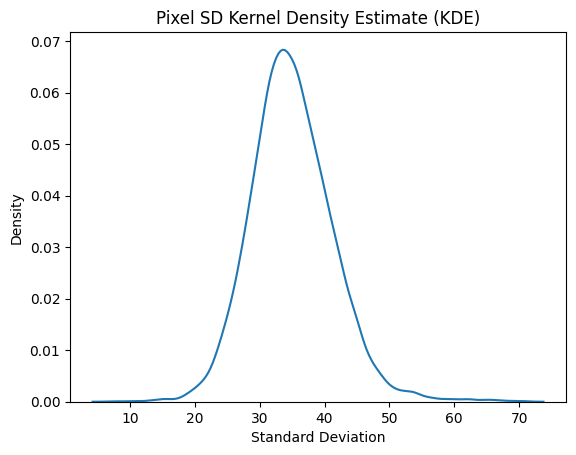

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.kdeplot(data=dataset, x="Std Dev")
plt.title('Pixel SD Kernel Density Estimate (KDE)')
plt.xlabel('Standard Deviation')

plt.savefig(f'{getcwd()}/../plots/std_kde.svg', format='svg')
plt.show()

- Pixels mean is a metric that isn't very useful for extracting insigths;
- Although, we can see in the graph below that the vast majority of the images aren't "too dark" or "too bright".

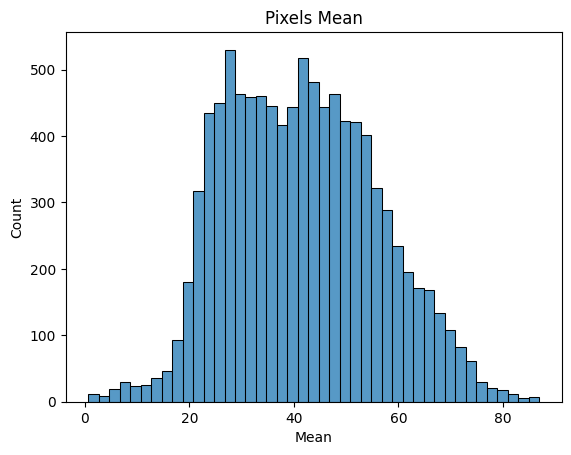

In [28]:
sns.histplot(data=dataset, x='Pixels Mean')
plt.title('Pixels Mean')
plt.xlabel('Mean')

plt.savefig(f'{getcwd()}/../plots/mean_hist.svg', format='svg')
plt.show()

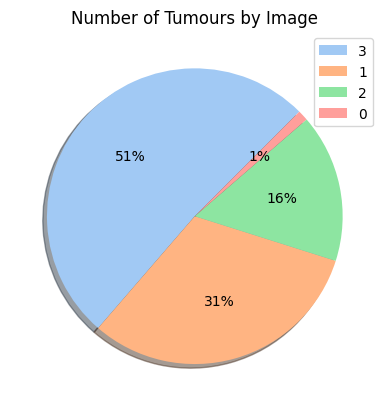

In [29]:
split = labels_csv['Total'].value_counts()
colors = sns.color_palette('pastel')[0:5]

plt.pie(split, colors=colors, shadow=True, startangle=45, autopct='%.0f%%')
plt.title('Number of Tumours by Image')
plt.legend([3, 1, 2, 0], loc='best')

plt.savefig(f'{getcwd()}/../plots/tumour_qtt_dist.svg', format='svg')
plt.show()

In [30]:
!pip install -U kaleido -q
import plotly.express as px


amount = labels_csv[['Glioma', 'Meningioma', 'Metastatic', 'No Tumour']].sum()
fig = px.bar(x=['Glioma', 'Meningioma', 'Metastatic', 'No Tumour'], y=amount,
             color=['blue', 'blue', 'blue', 'red'], title='Class Distribution',
             labels={'x': 'Class', 'y': 'Amount'}, width=800, height=600)

fig.update_layout(showlegend=False)
fig.show()
fig.write_image(f'{getcwd()}/../plots/class_dist.svg')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 7.0 MB/s eta 0:00:00


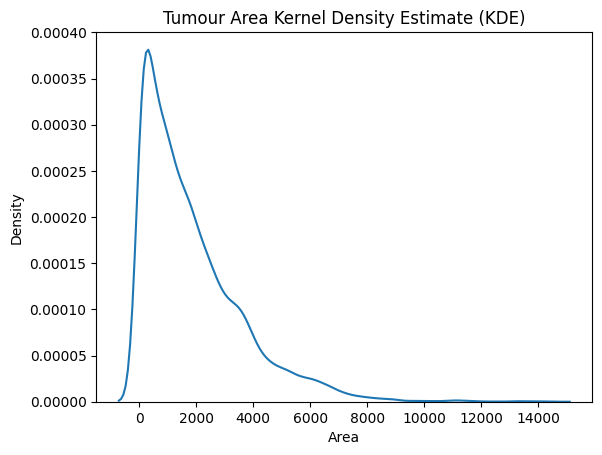

In [31]:
sns.kdeplot(data=coords_csv, x='Area')
plt.title('Tumour Area Kernel Density Estimate (KDE)')
plt.xlabel('Area')

plt.savefig(f'{getcwd()}/../plots/area_kde.svg', format='svg')
plt.show()

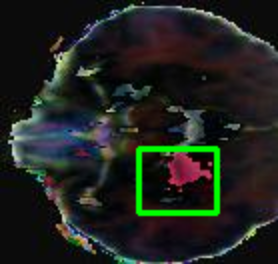

In [32]:
from google.colab.patches import cv2_imshow


# Visualizing tumours
img_filter = labels_csv.query('Glioma == 1 & Meningioma == 0 & Metastatic == 0 & `No Tumour` == 0')['File Name'].iloc[3]
my_img = cv.imread(f'Brain Tumor Detection/train/images/{img_filter.replace(".txt", ".jpg")}')

with open(f'Brain Tumor Detection/train/labels/{img_filter}', 'r') as txtfile:
    for line in txtfile:
        tumour = line.strip().split()
        _, x1, y1, x2, y2 = calculate_bounding_boxes(instance=tumour, width=my_img.shape[0],
                                                     height=my_img.shape[1])
        cv.rectangle(my_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        my_img = cv.resize(my_img, None, fx=2, fy=2)

cv2_imshow(my_img)